# Denoising Diffusion Probabilistic Models with MedNIST Dataset Bundle 

This notebook discusses and uses the MONAI bundle it's included in for generating images from the MedNIST dataset using diffusion models. This is based off the 2d_ddpm_tutorial_ignite.ipynb notebook with a few changes.

The bundle defines training and inference scripts whose use will be described here along with visualisations. The assumption with this notebook is that it's run within the bundle's `docs` directory and that the environment it runs in has `MONAI` and `GenerativeModels` installed. The command lines given are known to work in `bash` however may be problematic in Windows.

First thing to do is import libraries and verify MONAI is present:

In [1]:
import os
import shutil
import tempfile
from pathlib import Path

import torch

import matplotlib.pyplot as plt
import monai
from monai.bundle import ConfigParser

# path to the bundle directory, this assumes you're running the notebook in its directory
bundle_root = str(Path(".").absolute().parent)

monai.config.print_config()

MONAI version: 1.1.0+45.g1a018a7b
Numpy version: 1.21.5
Pytorch version: 1.12.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 1a018a7b3034a86360d999a6bcc796bad330bba4
MONAI __file__: /home/localek10/workspace/monai/MONAI_mine/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
ITK version: 5.2.1
Nibabel version: 4.0.2
scikit-image version: 0.19.2
Pillow version: 9.2.0
Tensorboard version: 2.9.0
gdown version: 4.5.1
TorchVision version: 0.13.1
tqdm version: 4.64.0
lmdb version: 1.2.1
psutil version: 5.9.0
pandas version: 1.4.3
einops version: 0.6.0
transformers version: 4.18.0
mlflow version: 1.28.0
pynrrd version: 0.4.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
dataset_dir = tempfile.mkdtemp() if directory is None else directory
print(dataset_dir)

/tmp/tmpw33bol9_


A bundle can be run on the command line using the Fire library or by parsing the configuration manually then getting parsed content objects. The following is the command to train the network for the default number of epochs. It will define values in the config files which need to be set for a particular run, such as the dataset directory created above, and setting the PYTHONPATH variable. The configuration for this bundle is split into 4 yaml files, one having common definitions for training and inference, one to enable multi-GPU training, and one each for training and inference. Their combinations determine what your final configuration is, in this case the common and train files produce a training script. 

In [ ]:
# multiple config files need to be specified this way with '' quotes, variable used in command line must be in "" quotes
configs=f"'{bundle_root}/configs/common.yaml', '{bundle_root}/configs/train.yaml'"

!PYTHONPATH={bundle_root} python -m monai.bundle run training \
    --meta_file {bundle_root}/configs/metadata.json \
    --config_file "{configs}" \
    --logging_file {bundle_root}/configs/logging.conf \
    --bundle_root {bundle_root} \
    --dataset_dir {dataset_dir}

The test inference script can then be invoked as such to produce an output tensor saved to the given file with a randomly generated image. The `ckpt_path` value should point to the final checkpoint file created during the above training run, which will be in a subdirectory of `./result`. The training script's default behaviour is to create a new timestamped subdirectory in `./result` for every new run, this can be explicitly set by providing a `output_dir` value on the command line.

2023-02-16 21:00:18,139 - INFO - --- input summary of monai.bundle.scripts.run ---
2023-02-16 21:00:18,139 - INFO - > runner_id: 'testing'
2023-02-16 21:00:18,139 - INFO - > meta_file: '/home/localek10/workspace/monai/GenerativeModels/model-zoo/models/mednist_ddpm/bundle/configs/metadata.json'
2023-02-16 21:00:18,139 - INFO - > config_file: ('/home/localek10/workspace/monai/GenerativeModels/model-zoo/models/mednist_ddpm/bundle/configs/common.yaml',
 '/home/localek10/workspace/monai/GenerativeModels/model-zoo/models/mednist_ddpm/bundle/configs/infer.yaml')
2023-02-16 21:00:18,139 - INFO - > ckpt_path: './results/output_230215_174009/model_final_iteration=75000.pt'
2023-02-16 21:00:18,140 - INFO - > bundle_root: '/home/localek10/workspace/monai/GenerativeModels/model-zoo/models/mednist_ddpm/bundle'
2023-02-16 21:00:18,140 - INFO - > out_file: 'test.pt'
2023-02-16 21:00:18,140 - INFO - ---


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 97.10it/s]
[[[], []], null]


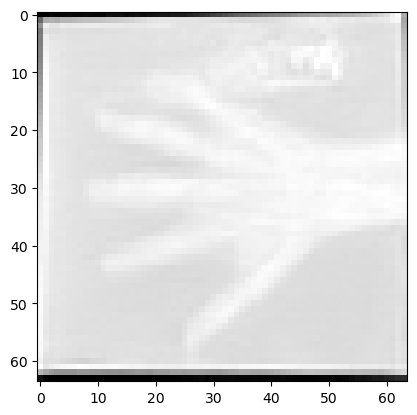

In [36]:
configs=f"'{bundle_root}/configs/common.yaml', '{bundle_root}/configs/infer.yaml'"

!PYTHONPATH={bundle_root} python -m monai.bundle run testing \
    --meta_file {bundle_root}/configs/metadata.json \
    --config_file "{configs}" \
    --ckpt_path ./results/output_230215_174009/model_final_iteration=75000.pt \
    --bundle_root {bundle_root} \
    --out_file test.pt

test = torch.load("test.pt", map_location="cpu")

plt.imshow(test[0, 0], vmin=0, vmax=1, cmap="gray")

The same can be done by creating the parser object, filling in its configuration, then resolving the Python objects from the constructed bundle data:

100%|██████████| 1000/1000 [00:09<00:00, 101.06it/s]


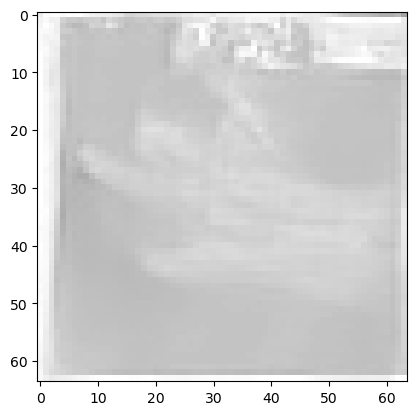

In [24]:
import sys

sys.path.append(bundle_root)  # make sure we load the script files we need

# configure the parser from the bundle's information
cp = ConfigParser()
cp.read_meta(f"{bundle_root}/configs/metadata.json")
cp.read_config([f"{bundle_root}/configs/common.yaml", f"{bundle_root}/configs/infer.yaml"])
cp["bundle_root"] = bundle_root
cp["ckpt_path"] = "./results/output_230215_174009/model_final_iteration=75000.pt"

cp.get_parsed_content("load_state")  # load the saved state from the checkpoint just be resolving this value

device = cp.get_parsed_content("device")  # device used by the bundle
sample = cp.get_parsed_content("sample")  # test sampling function

image_dim = cp["image_dim"]  # get the stored dimension value, no need to resolve anything

noise = torch.rand(1, 1, image_dim, image_dim).to(device)  # or cp.get_parsed_content("noise")

test = sample(noise)

plt.imshow(test[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")

Multi-GPU can be enabled by including the `train_multigpu.yaml` configuration file:

In [ ]:
configs=f"'{bundle_root}/configs/common.yaml', '{bundle_root}/configs/train.yaml', '{bundle_root}/configs/train_multigpu.yaml'"

!PYTHONPATH={bundle_root} torchrun --standalone --nnodes=1 --nproc_per_node=2 -m monai.bundle run training \
    --meta_file {bundle_root}/configs/metadata.json \
    --config_file "{configs}" \
    --logging_file {bundle_root}/configs/logging.conf \
    --bundle_root {bundle_root} \
    --dataset_dir {dataset_dir}

In [ ]:
if directory is None:
    shutil.rmtree(dataset_dir)